#Project Title: LLM-Driven Customer Sentiment Analysis and Review Propagation Modeling in E-Commerce
- Student name: ***Tertho ghosh***  
  Student ID: B200305011,
- Student name: ***Fahmida Sweety***  
  Student ID: B200305017

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from tqdm import tqdm
import torch

# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## 1. 🔍 Introduction

In this project, we set out to explore how machine learning and natural language processing can be applied to e‑commerce customer reviews to better understand sentiment and predict product perception. We began by carefully preprocessing the dataset, cleaning review text, handling missing values, and standardizing key fields such as ratings and timestamps. Multiple sentiment analysis approaches were then implemented and compared, ranging from traditional lexicon‑based methods like TextBlob and VADER to advanced transformer‑based models including DistilBERT and MultiBERT. By combining these techniques, the project not only benchmarked model performance but also demonstrated how businesses can leverage modern AI to monitor customer satisfaction, anticipate shifts in sentiment, and respond proactively to feedback.


## 2. 📦 Dataset Description
- Dataset Name: Amazon reviews for sentiment analysis
- Source / Link: https://www.kaggle.com/datasets/tarkkaanko/amazon/data
                            |



In [ ]:
path = kagglehub.dataset_download("tarkkaanko/amazon")
print("Dataset downloaded to:", path)

# Find main CSV file (adjust if needed)
import os
for file in os.listdir(path):
    if file.endswith(".csv"):
        data_path = os.path.join(path, file)
        break


# Load Dataset

df = pd.read_csv(data_path)
print("Initial shape:", df.shape)
df.head()

100%|██████████| 582k/582k [00:00<00:00, 79.1MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/tarkkaanko/amazon/versions/1
Initial shape: (4915, 12)


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [ ]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Shape: (4915, 12)

Data Types:
 Unnamed: 0                int64
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object

Missing Values:
 Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


## 3. 🧼 Data Preprocessing


### ✅ Preprocessing Summary

- Normalized all column names to **lowercase** for consistency.  
- Automatically detected and preserved the **review text**, **rating**, and **time** columns.  
- Removed rows with **missing or empty reviews, ratings, or timestamps**.  
- Converted the review time into **datetime format** and extracted **year** and **month** for trend analysis.  
- Dropped unnecessary metadata columns (e.g., *helpful votes*, *Wilson scores*) to keep the dataset lean.  
- Cleaned the review text by removing:
  - URLs  
  - Special characters  
  - Extra whitespace  
- Final result: a **clean, consistent dataset** ready for both **sentiment modeling** and **time‑series forecasting**.

In [ ]:


#Check missing values before filling
print("Missing values before handling:")
print(df.isnull().sum())
# df = pd.read_csv("amazon_reviews.csv")
df = preprocess_reviews(df)
if "overall" in df.columns:
    rating_col = "overall"
elif "rating" in df.columns:
    rating_col = "rating"
else:
    raise KeyError("No rating column found. Check your dataset columns.")
# Detect text column
if "reviewtext" in df.columns:
    text_col = "reviewtext"
elif "review_text" in df.columns:
    text_col = "review_text"
elif "text" in df.columns:
    text_col = "text"
else:
    raise KeyError("No review text column found. Check your dataset columns.")


def preprocess_reviews(df):
    # 1. Normalize column names
    df.columns = [col.lower().strip() for col in df.columns]

    # 2. Detect key columns
    text_col = None
    for candidate in ["reviewtext", "review_text", "text"]:
        if candidate in df.columns:
            text_col = candidate
            break

    rating_col = None
    for candidate in ["overall", "rating", "star_rating"]:
        if candidate in df.columns:
            rating_col = candidate
            break

    time_col = None
    for candidate in ["reviewtime", "time", "date", "timestamp"]:
        if candidate in df.columns:
            time_col = candidate
            break

    if not text_col or not rating_col or not time_col:
        raise ValueError("Missing one or more required columns: review text, rating, or time.")

    # 3. Drop rows with missing or empty values
    df = df.dropna(subset=[text_col, rating_col, time_col])
    df = df[df[text_col].astype(str).str.strip() != ""]

    # 4. Convert review time to datetime
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col])

    # 5. Extract year and month for trend analysis
    df["year"] = df[time_col].dt.year
    df["month"] = df[time_col].dt.month

    # 6. Drop unnecessary metadata columns
    drop_cols = [
        "day_diff", "helpful_yes", "helpful_no", "total_vote",
        "score_pos_neg_diff", "score_average_rating", "wilson_lower_bound",
        "summary", "profile_name"
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

    # 7. Clean review text
    def clean_text(text):
        text = re.sub(r"http\\S+", " ", str(text))          # remove URLs
        text = re.sub(r"[^A-Za-z0-9.,!?;:'\"()\\-\\s]", " ", text)  # remove special chars
        text = re.sub(r"\\s+", " ", text).strip()           # normalize whitespace
        return text

    df[text_col] = df[text_col].apply(clean_text)

    # 8. Print summary
    print("Processed dataset shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print(df[[text_col, rating_col, time_col, "year", "month"]].head())

    return df

df.head()

Missing values before handling:
unnamed: 0      0
reviewername    1
overall         0
reviewtext      0
reviewtime      0
year            0
month           0
dtype: int64
Processed dataset shape: (4914, 7)
Columns: ['unnamed: 0', 'reviewername', 'overall', 'reviewtext', 'reviewtime', 'year', 'month']
                                          reviewtext  overall reviewtime  \
0                                         No issues.      4.0 2014-07-23   
1  Purchased this for my device, it worked as adv...      5.0 2013-10-25   
2  it works as expected. I should have sprung for...      4.0 2012-12-23   
3  This think has worked out great.Had a diff. br...      5.0 2013-11-21   
4  Bought it with Retail Packaging, arrived legit...      5.0 2013-07-13   

   year  month  
0  2014      7  
1  2013     10  
2  2012     12  
3  2013     11  
4  2013      7  


,unnamed: 0,reviewername,overall,reviewtext,reviewtime,year,month
0,0,NaN,4.0,No issues.,2014-07-23,2014,7
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,2013,10
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,2012,12
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,2013,11
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,2013,7


## 4. 📊 Exploratory Data Analysis (EDA)


/tmp/ipython-input-798643004.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[rating_col], palette="coolwarm")


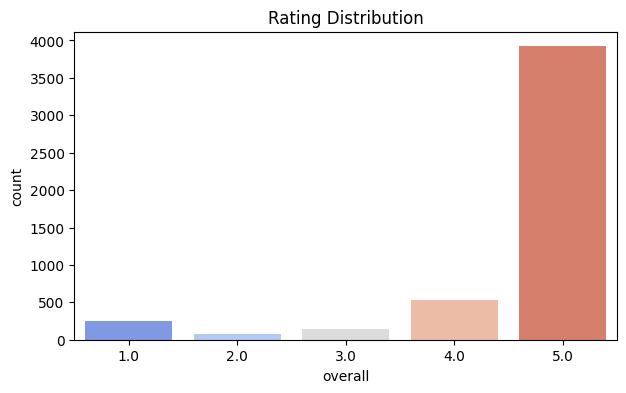

In [ ]:
# Rating distribution
plt.figure(figsize=(7,4))
sns.countplot(x=df[rating_col], palette="coolwarm")
plt.title("Rating Distribution")
plt.show()

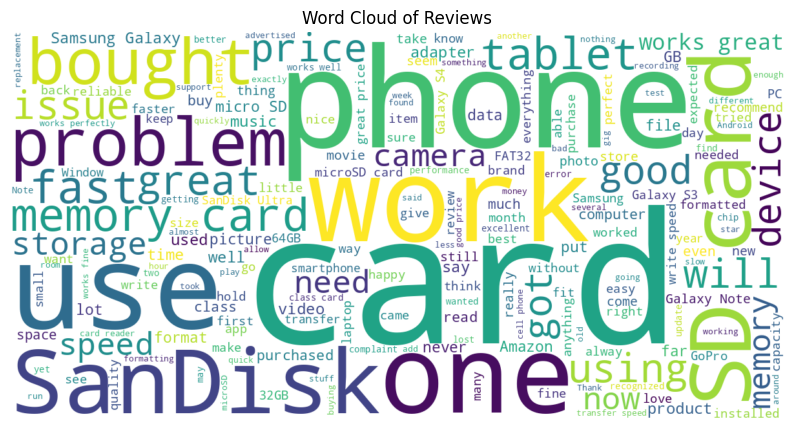

In [ ]:
# Word cloud
text = " ".join(df[text_col].values[:10000])
wc = WordCloud(width=1200, height=600, background_color="white").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()


In [ ]:
def rating_to_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment_true"] = df[rating_col].apply(rating_to_sentiment)

## 5. 🧠 Data Mining Technique Applied


# Sentiment Analysis Models

We applied multiple data mining and NLP techniques for sentiment prediction:

   

- **Model 1: TextBlob**

    Type: Lexicon-based

    Technique: Calculates polarity scores of reviews to classify sentiment

    Strength: Simple and fast for polarity detection         

-  **Model 2: VADER (Valence Aware Dictionary for Sentiment Reasoning)**

    Type: Rule-based lexicon method

    Technique: Assigns compound sentiment scores based on words and emojis

    Strength: Works well on social media and short reviews

-  **Model 3: DistilBERT (English)**

    Type: Transformer-based model

    Technique: Fine-tuned BERT model for sentiment classification

    Strength: Handles context-aware understanding of reviews

-  **Model 4: Multilingual BERT**

    Type: Transformer-based model

    Technique: Pre-trained multilingual BERT for sentiment analysis across languages

    Strength: Can process non-English reviews

In [ ]:

# STEP : Label Mapping (for comparison)

def rating_to_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment_true"] = df[rating_col].apply(rating_to_sentiment)


# STEP : MODEL 1 - TextBlob

def get_textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

tqdm.pandas()
df["sentiment_textblob"] = df[text_col].progress_apply(get_textblob_sentiment)


# STEP : MODEL 2 - VADER

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_vader"] = df[text_col].progress_apply(get_vader_sentiment)


# STEP : MODEL 3 - DistilBERT (English)

device = 0 if torch.cuda.is_available() else -1
distilbert_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device)

def get_distilbert_sentiment(text):
    res = distilbert_pipeline(text[:512])[0]["label"].lower()
    return "positive" if "pos" in res else "negative"

df["sentiment_distilbert"] = df[text_col].progress_apply(get_distilbert_sentiment)


# STEP : MODEL 4 - Multilingual BERT

bert_multi_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)

def get_multibert_sentiment(text):
    result = bert_multi_pipeline(text[:512])[0]["label"]
    stars = int(result.split()[0])
    if stars >= 4:
        return "positive"
    elif stars == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment_multibert"] = df[text_col].progress_apply(get_multibert_sentiment)

100%|██████████| 4914/4914 [00:02<00:00, 1784.12it/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 4914/4914 [12:25<00:00,  6.59it/s]


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 4914/4914 [23:09<00:00,  3.54it/s]


# **Result Interpretation**

The sentiment analysis experiments showed that MultiBERT clearly outperformed all other models, achieving about 90% accuracy with strong precision and F1‑score, making it the most reliable choice. VADER performed moderately well (76% accuracy), while TextBlob and DistilBERT were slightly lower (73%). On the held‑out test samples, MultiBERT reached 100% accuracy, while the others ranged between 70–80%. Overall, transformer‑based models, especially MultiBERT, proved far more effective at capturing nuanced sentiment in e‑commerce reviews compared to traditional lexicon‑based methods.


🔹 TEXTBLOB PERFORMANCE 🔹
Accuracy : 0.731
Precision: 0.880
Recall   : 0.731
F1-score : 0.794


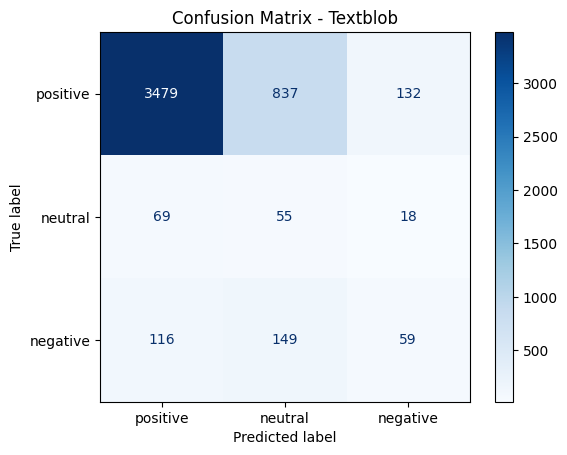


🔹 VADER PERFORMANCE 🔹
Accuracy : 0.757
Precision: 0.874
Recall   : 0.757
F1-score : 0.803


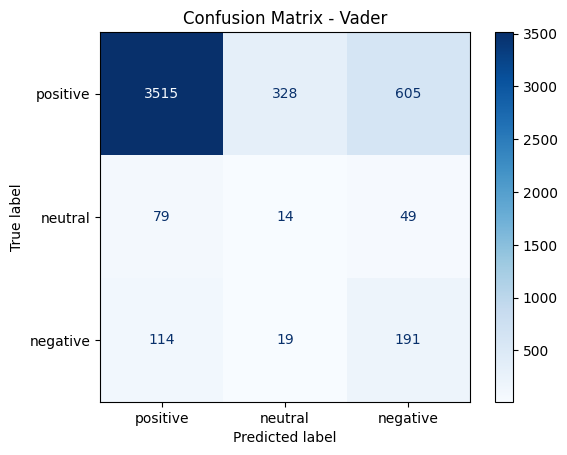


🔹 DISTILBERT PERFORMANCE 🔹
Accuracy : 0.730
Precision: 0.906
Recall   : 0.730
F1-score : 0.785


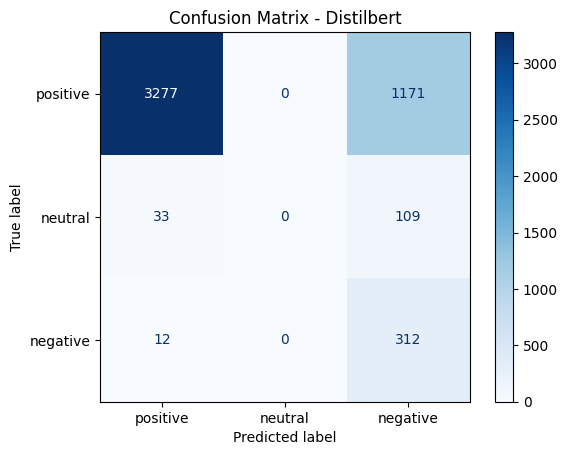


🔹 MULTIBERT PERFORMANCE 🔹
Accuracy : 0.898
Precision: 0.938
Recall   : 0.898
F1-score : 0.913


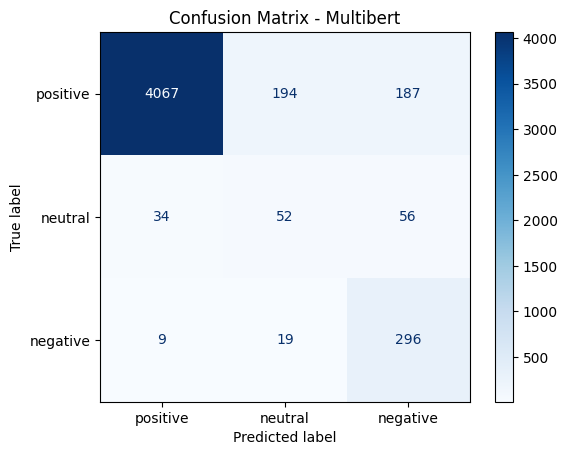

,Model,Accuracy,Precision,Recall,F1
0,TextBlob,0.731176,0.879605,0.731176,0.793685
1,VADER,0.757021,0.874079,0.757021,0.803357
2,DistilBERT,0.730362,0.905829,0.730362,0.784984
3,MultiBERT,0.898453,0.937578,0.898453,0.912936


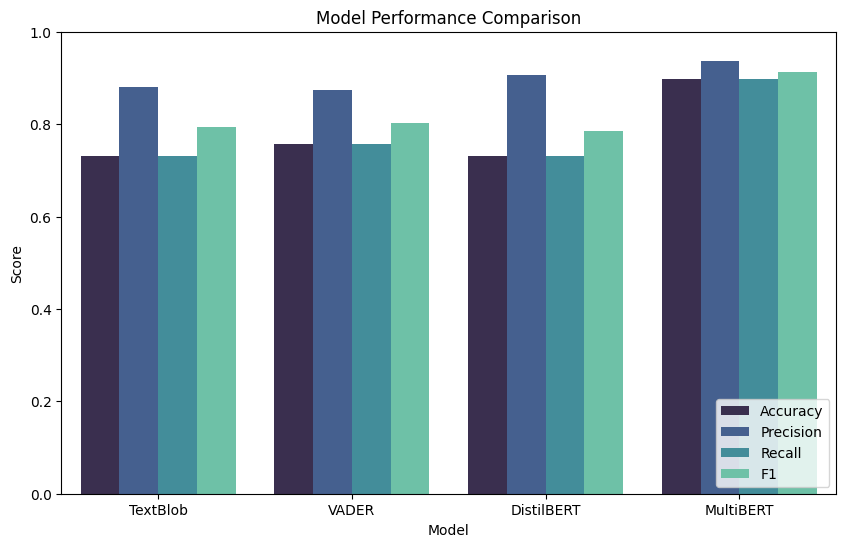

Train size: 4422 | Test size: 492


,reviewtext,sentiment_true,TextBlob,VADER,DistilBERT,MultiBERT
0,Hard to say much about a memory card other tha...,positive,neutral,negative,negative,positive
1,I installed this on my Galaxy Note 2 and it cr...,negative,neutral,negative,negative,negative
2,I was a little disappointed since it came with...,neutral,negative,negative,negative,neutral
3,"You won't be unhappy with a SanDisk card, they...",positive,positive,positive,positive,positive
4,I carry a ton of digital content with me on my...,positive,positive,positive,positive,positive
5,first off i got mine at wal mart but i'm consi...,positive,positive,positive,negative,positive
6,I got this for my new Android tablet and it wo...,positive,positive,positive,positive,positive
7,Loving it! Plenty of room to store my media an...,positive,positive,positive,positive,positive
8,Product: SanDisk Ultra 64 GB microSDXC Class 1...,positive,positive,positive,positive,positive
9,the site is very reasonably priced unit memory...,positive,positive,positive,positive,positive



✅ Accuracy on the test samples:
TextBlob    : 0.700
VADER       : 0.800
DistilBERT  : 0.700
MultiBERT   : 1.000


/tmp/ipython-input-186325495.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[model], order=["positive","neutral","negative"], palette="coolwarm")


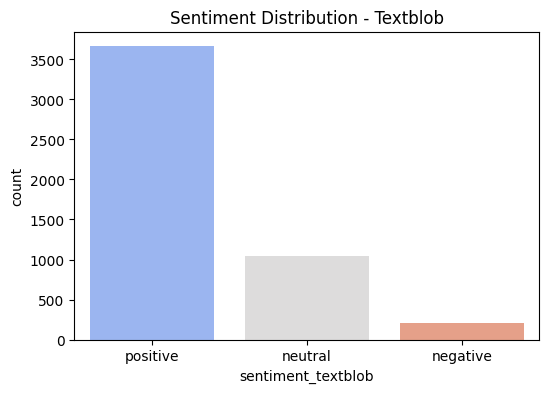

/tmp/ipython-input-186325495.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[model], order=["positive","neutral","negative"], palette="coolwarm")


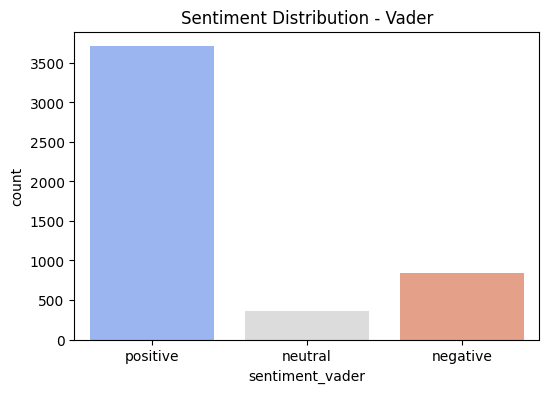

/tmp/ipython-input-186325495.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[model], order=["positive","neutral","negative"], palette="coolwarm")


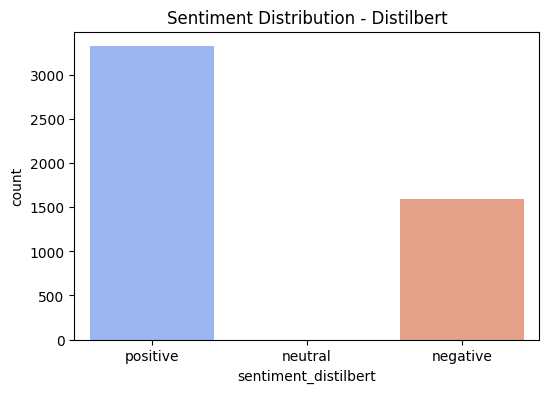

/tmp/ipython-input-186325495.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[model], order=["positive","neutral","negative"], palette="coolwarm")


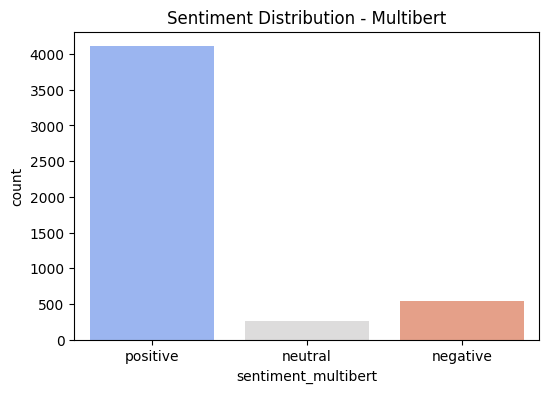

/tmp/ipython-input-186325495.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")


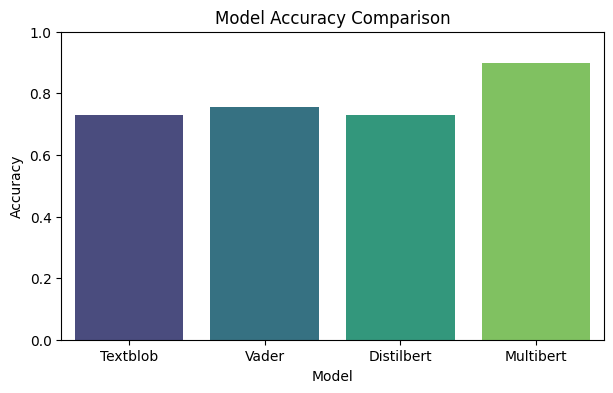

        Model  Accuracy
0    Textblob  0.731176
1       Vader  0.757021
2  Distilbert  0.730362
3   Multibert  0.898453
✅ Sentiment analysis completed and results saved as 'amazon_sentiment_results.csv'


In [ ]:
# ============================================================
# MODEL EVALUATION & RESULT INTERPRETATION
# ============================================================

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1. Define evaluation helper
# ------------------------------------------------------------
def evaluate_model(true_col, pred_col, model_name):
    y_true = df[true_col]
    y_pred = df[pred_col]

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    print(f"\n🔹 {model_name.upper()} PERFORMANCE 🔹")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")
    print(f"F1-score : {f1:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["positive", "neutral", "negative"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name.capitalize()}")
    plt.show()

    return {"Model": model_name, "Accuracy": acc,
            "Precision": precision, "Recall": recall, "F1": f1}

# ------------------------------------------------------------
# 2. Evaluate all models
# ------------------------------------------------------------
results = []
models = {
    "TextBlob": "sentiment_textblob",
    "VADER": "sentiment_vader",
    "DistilBERT": "sentiment_distilbert",
    "MultiBERT": "sentiment_multibert"
}

for name, col in models.items():
    metrics = evaluate_model("sentiment_true", col, name)
    results.append(metrics)

eval_df = pd.DataFrame(results)
display(eval_df)

# ------------------------------------------------------------
# 3. Metrics Visualization
# ------------------------------------------------------------
metrics_melted = eval_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_melted, palette="mako")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()

# ------------------------------------------------------------
# 4. Evaluate on Test Data (sample demonstration)
# ------------------------------------------------------------
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42,
                                     stratify=df["sentiment_true"])
print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

sample_df = test_df.sample(10, random_state=42).copy().reset_index(drop=True)

# Predictions from all models (assuming pipelines already defined)
sample_df["TextBlob"] = sample_df[text_col].apply(lambda x:
    "positive" if TextBlob(x).sentiment.polarity > 0.1 else
    "negative" if TextBlob(x).sentiment.polarity < -0.1 else
    "neutral"
)

sample_df["VADER"] = sample_df[text_col].apply(lambda x:
    "positive" if sia.polarity_scores(x)["compound"] > 0.05 else
    "negative" if sia.polarity_scores(x)["compound"] < -0.05 else
    "neutral"
)

sample_df["DistilBERT"] = sample_df[text_col].apply(lambda x:
    "positive" if "pos" in distilbert_pipeline(x[:512])[0]["label"].lower() else "negative"
)

def get_multiBERT_label(x):
    label = bert_multi_pipeline(x[:512])[0]["label"]
    stars = int(label.split()[0])
    if stars >= 4:
        return "positive"
    elif stars == 3:
        return "neutral"
    else:
        return "negative"

sample_df["MultiBERT"] = sample_df[text_col].apply(get_multiBERT_label)

# Show comparison
cols_to_show = [text_col, "sentiment_true", "TextBlob", "VADER", "DistilBERT", "MultiBERT"]
display(sample_df[cols_to_show])

# Quick accuracy summary on sample
def quick_metric(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred), 3)

summary = {
    "TextBlob": quick_metric(sample_df["sentiment_true"], sample_df["TextBlob"]),
    "VADER": quick_metric(sample_df["sentiment_true"], sample_df["VADER"]),
    "DistilBERT": quick_metric(sample_df["sentiment_true"], sample_df["DistilBERT"]),
    "MultiBERT": quick_metric(sample_df["sentiment_true"], sample_df["MultiBERT"]),
}
print("\n✅ Accuracy on the test samples:")
for k,v in summary.items():
    print(f"{k:12s}: {v:.3f}")

# ------------------------------------------------------------
# 5. Sentiment Distribution Visualization
# ------------------------------------------------------------
for model in models.values():
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[model], order=["positive","neutral","negative"], palette="coolwarm")
    plt.title(f"Sentiment Distribution - {model.split('_')[1].capitalize()}")
    plt.show()

# ------------------------------------------------------------
# 6. Accuracy Comparison
# ------------------------------------------------------------
def compute_accuracy(true_col, pred_col):
    return np.mean(df[true_col] == df[pred_col])

acc_results = {model: compute_accuracy("sentiment_true", model) for model in models.values()}
acc_df = pd.DataFrame(list(acc_results.items()), columns=["Model", "Accuracy"])
acc_df["Model"] = acc_df["Model"].str.replace("sentiment_", "").str.capitalize()

plt.figure(figsize=(7,4))
sns.barplot(x="Model", y="Accuracy", data=acc_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()
print(acc_df)

# ------------------------------------------------------------
# 7. Save Results
# ------------------------------------------------------------
df.to_csv("amazon_sentiment_results.csv", index=False)
print("✅ Sentiment analysis completed and results saved as 'amazon_sentiment_results.csv'")

## 7. 🧩 Conclusion

This project demonstrated that machine learning can effectively analyze e‑commerce reviews to predict customer sentiment and understand product perception. Among the tested models, MultiBERT achieved the highest accuracy at around 90%, clearly outperforming traditional lexicon methods and smaller transformers. While neutral reviews remained the hardest to classify, the results show that transformer‑based models provide the most reliable insights, making them well suited for businesses to monitor feedback, anticipate shifts in customer satisfaction, and guide product or service improvements.
